In [3]:
import os
import sys
from matplotlib import pyplot as plt
from PIL import Image
from skimage.io import imread, imshow, imsave
from skimage import img_as_float, img_as_ubyte
from numpy import roll, clip, round, dstack
import numpy as np
from skimage import color
import math
from matplotlib.pyplot import hist
import random
from scipy import ndimage

In [4]:
def entropy2(one, two):
    sum_one = 0
    sum_two = 0
    size = len(one)*len(one[0])
    for i in range(len(one)):
        for j in range(len(one[0])):
            #pi = math.fabs(one[i,j]-two[i,j])/size
            p1 = math.fabs(one[i,j]/size)
            p2 = math.fabs(two[i,j]/size)
            #res += pi* math.log2(pi)
            sum_one += p1* math.log2(p1)
            sum_two += p2* math.log2(p2)
    print(sum_one, sum_two)
    return math.fabs(sum_one - sum_two)
def entropy4(one,two):
    res1 = 0 
    res2 = 0
    size = one.shape[0]*one.shape[1]
    values1, bin_edges1, patches1 = hist(one.ravel(), bins=range(257))
    values2, bin_edges2, patches2 = hist(two.ravel(), bins=range(257))
    for i in range(len(values1)):
        p1 = math.fabs(values1[i]/size)
        p2 = math.fabs(values2[i]/size)
        #print(p1, p2)
        if (p1>0):
            res1 += p1* math.log2(p1)
        if (p2>0):
            res2 += p2* math.log2(p2)
    print(res1, res2)
    return math.fabs(res1-res2)
def msi(one, two):
    e = 0
    for i in range(len(one)):
        for j in range(len(one[0])):
            e += round(one[i][j] - two[i][j])**2
    e = (e / (one.shape[0]*one.shape[1] - 1))**(1/2)
    return e

In [5]:
def splice(img1, img2):
    y = min(img1.shape[1],img2.shape[1])
    x = img1.shape[0]/2+img2.shape[0]/2
    x1 = img1.shape[0]/2
    new_img = np.zeros((x, y))
    new_img = img1
    new_img[x/2:x, 0:y] = img2[img2.shape[0]/2:img2.shape[0], 0:y]
    return new_img
def splice2(img1, img2):
    y = min(img1.shape[1],img2.shape[1])
    x = img1.shape[0]/2+img2.shape[0]/2
    x1 = img1.shape[0]/2
    new_img = np.zeros((x, y))
    new_img = np.copy(img1)
    new_img[0:x, y/2:y] = np.copy(img2[0:x, y/2:y])
    return new_img

In [6]:
def yuvToRGB(y, u, v):
    rd = y[:,:] + 1.402*(v[:,:] - 128)
    gr = y[:,:] - 0.34414*(u[:,:] - 128) - 0.71414*(v[:,:] - 128)
    bl = y[:,:] + 1.772*(u[:,:] - 128)
    return rd, gr, bl
def make_u(rgb):
    return (-0.1687*rgb[:,:,0] - 0.3313*rgb[:,:,1] + 0.5*rgb[:,:,2] + 128)
def make_v(rgb):
    return (0.5*rgb[:,:,0] - 0.4187*rgb[:,:,1] - 0.0813*rgb[:,:,2] + 128)
def make_y(rgb):
    return (0.299*rgb[:,:,0] + 0.587*rgb[:,:,1] + 0.114*rgb[:,:,2])
def rgbToYUV(rgb):
    u = -0.1687*rgb[:,:,0] - 0.3313*rgb[:,:,1] + 0.5*rgb[:,:,2] + 128
    v = 0.5*rgb[:,:,0] - 0.4187*rgb[:,:,1] - 0.0813*rgb[:,:,2] + 128
    y = 0.299*rgb[:,:,0] + 0.587*rgb[:,:,1] + 0.114*rgb[:,:,2]
    return y, u, v

In [7]:
#avg 


In [106]:
les = imread('lab2/les.jpg')
#les = color.rgb2gray(imread('lab2/view3.jpg'))
view = imread('lab2/view3.jpg')

In [9]:
# матрица фильтра размытия
n1on9 = np.array([[1/9, 1/9, 1/9],[1/9, 1/9, 1/9],[1/9, 1/9, 1/9]])
n9 = np.array([[-1, -1, -1],[-1, 9, -1],[-1, -1, -1]])
# Гаусс
nG = np.array(
    [[0.003, 0.013, 0.022, 0.013, 0.003],
     [0.013, 0.059, 0.097, 0.059, 0.013],
     [0.022, 0.097, 0.159, 0.097, 0.022],
     [0.013, 0.059, 0.097, 0.059, 0.013], 
     [0.003, 0.013, 0.022, 0.013, 0.003]])
n1on16 = np.array([[1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]])
n1to1 = np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]])

In [10]:
def summa(array):
    r = 0
    g = 0
    b = 0
    for i in range(len(array)):
        r += array[i][0]
        g += array[i][1]
        b += array[i][2]
    return np.array((r,g,b))
def IndexesBox(parm):
    box = []
    if(parm.find('x')>0):
        size1 = int(parm[0:parm.index('x')])
        size2 = int(parm[parm.index('x')+1:])
        for i in range(0, size1):
            box.append([])
            for j in range(0, size2):
                box[len(box)-1].append([])

    box[len(box)//2][len(box[len(box)//2])//2]=[0,0]
    for i in range(len(box)):
        if(i<len(box)//2):
            ordinatus = -(len(box)//2 - i)
        else: 
            ordinatus = i - len(box)//2
        if(len(box[i])>0):
            for j in range(len(box[i])):
                if(j<len(box[i])//2):
                    abscissa = -(len(box[i])//2 - j)
                else:
                    abscissa = j - len(box[i])//2
                box[i][j] = [ordinatus, abscissa]
        else:
            abscissa = 0
            box[i] = [ordinatus, abscissa]
    return box
def bundle(img, nuclear):
    new_img = img.copy()
    y, u, v = rgbToYUV(img)
    #print(y[0:10, 0:10])
    new_y = y.copy()
    if (len(nuclear)==len(nuclear[0])):
        parm = str(len(nuclear))+'x'+str(len(nuclear))
        box = IndexesBox(parm)
        #box = IndexesBox(len(nuclear)+'x'+len(nuclear))
        #for curr_row in range(img.shape[0]):
        for curr_row in range(3):
            #for curr_col in range(img.shape[1]):
            for curr_col in range(3):
                #for_sum = []
                summ = 0
                print(img[curr_row, curr_col])
                #print([curr_row, curr_col])
                for i in range(len(box)):
                    for j in range(len(box[i])):
                        ordinatus = box[i][j][0]
                        abscissa = box[i][j][1]
                        if(curr_row+box[i][j][0] < 0 or curr_row+box[i][j][0] > img.shape[0]):
                            ordinatus = ordinatus*(-1) - 1
                        if(curr_col+box[i][j][1] < 0 or curr_col+box[i][j][1] > img.shape[1]):
                            abscissa = abscissa*(-1) - 1
                        #print(box[i][j], [ordinatus, abscissa])
                        #print(nuclear[i][j], box[i][j], [ordinatus, abscissa], img[ordinatus][abscissa], img[ordinatus][abscissa]*nuclear[i][j])
                        #for_sum.append(y[ordinatus][abscissa]*1/9)
                        summ += y[ordinatus][abscissa]*1/9
                #print(for_sum)
                #print(summ)
                new_y[curr_row, curr_col] = summ
        #print(new_y[0:10, 0:10])
        print("_____________")
        r, g, b = yuvToRGB(new_y, u, v)
    return np.array((r, g, b)).astype('uint8')

In [11]:
def cycle(img, count, nuclear):
    new_img = img.copy()
    for i in range(count):
        new_img = bundle(new_img, nuclear)
    return new_img
les0 = cycle(les, 1, n1on9)
#les1 = cycle(les, 4, n1on9)
#les2 = cycle(les, 9, n1on9)
#les3 = cycle(les, 19, n1on9)
#les4 = cycle(les, 19, n1on16)
les5 = cycle(les, 1, n1to1)
imshow(les0)
plt.show()

[182 186 197]
[195 199 210]
[246 250 255]
[175 179 190]
[201 205 216]
[226 230 239]
[174 178 189]
[161 165 176]
[248 252 255]
_____________
[182 186 197]
[195 199 210]
[246 250 255]
[175 179 190]
[201 205 216]
[226 230 239]
[174 178 189]
[161 165 176]
[248 252 255]
_____________


TypeError: Invalid dimensions for image data

In [ ]:
les[0:3, 0:3]

In [12]:
les0[0:2, 0:10]

array([[[185, 138, 139, ...,  39,  38,  41],
        [127, 101, 101, ...,  39,  39,  42],
        [127, 101, 102, ...,  39,  40,  44],
        ..., 
        [230, 238, 242, ...,  32,  32,  36],
        [228, 216, 249, ...,  38,  35,  47],
        [234, 238, 238, ...,  37,  32,  40]],

       [[189, 142, 143, ...,  39,  38,  41],
        [131, 105, 105, ...,  39,  39,  42],
        [131, 105, 106, ...,  39,  40,  44],
        ..., 
        [233, 241, 245, ...,  32,  32,  36],
        [231, 219, 253, ...,  38,  35,  47],
        [237, 241, 241, ...,  37,  32,  40]]], dtype=uint8)

In [13]:
les[0:2, 0:10]

array([[[182, 186, 197],
        [195, 199, 210],
        [246, 250, 255],
        [227, 231, 240],
        [236, 240, 249],
        [ 95, 100, 106],
        [119, 124, 130],
        [234, 239, 245],
        [172, 175, 184],
        [229, 232, 241]],

       [[175, 179, 190],
        [201, 205, 216],
        [226, 230, 239],
        [230, 234, 243],
        [230, 234, 243],
        [222, 227, 233],
        [ 89,  94, 100],
        [150, 155, 161],
        [207, 210, 219],
        [129, 132, 141]]], dtype=uint8)

In [14]:
imshow(les0)
plt.show()

TypeError: Invalid dimensions for image data

после 19 применения box фильтра 3x3 результат на изображении перестаёт отображаться

In [15]:
imshow(difference_les2)
plt.show()

NameError: name 'difference_les2' is not defined

In [16]:
spliced_les3 = splice2(les, les3)
imshow(spliced_les3)
imsave('spliced_les3.jpg', spliced_les3)
difference_les3 = np.abs(les3 - les)
imsave('difference_les3.jpg', difference_les3)
plt.show()

NameError: name 'les3' is not defined

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


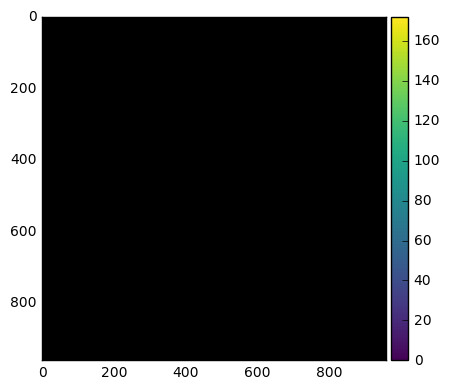

In [80]:
imshow(difference_les3)
plt.show()

светка предоставляет широкую вариацию ядер и следовательно применений к получению различных обработок изображений. однако требуется это складывается в большую вариацию переборов, для получения ощутимого, зрительно наглядного эффекта. 

In [130]:
def reflect(img):
    new_img = img.copy()
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            print(img.shape[0]-i-1, img.shape[1]-j-1)
            new_img[i, j] = img[img.shape[0]-i-1, img.shape[1]-j-1]
    return new_img
def addBorder(img, n):
    new_img = np.zeros((img.shape[0]+n*2, img.shape[1]+n*2, 3)).astype('uint8')
    new_img[n:new_img.shape[0]-n, n:new_img.shape[1]-n] = img
    for i in range(n):
        # top down left right
        new_img[i, n:img.shape[1]+n] = img[n-i,0:img.shape[1]] 
        new_img[img.shape[0]+n+i, n:img.shape[1]+n] = img[img.shape[0]-i-1, 0:img.shape[1]]
        new_img[n:img.shape[1]+n, i] = img[0:img.shape[1], n-i]
        new_img[n:img.shape[1]+n, img.shape[0]+n+i] = img[0:img.shape[1], img.shape[0]-i-1]
    
    for i in range(n):
        for j in range(n):
            # down-right down-left top-left top-right
            new_img[n+img.shape[0]+i, n+img.shape[1]+j] = img[img.shape[0]-i-1, img.shape[1]-j-1]
            new_img[n+img.shape[0]+i, j] = img[img.shape[0]-i-1, n-j-1]
            new_img[i, j] = img[n-i-1, n-j-1]
            new_img[i, n+img.shape[1]+j] = img[n-i-1, img.shape[1]-j-1]
    return new_img
def bundle2(img, nuclear):
    n = len(nuclear) - 1
    print(n)
    mid_img = addBorder(img.copy(), len(nuclear))
    res_img = img.copy()
    for i in range(n, n+img.shape[0]):
        for j in range(n, n+img.shape[1]):
            #print(i-n, ':', i+n-1, ' ', j-n, ':', j+n-1)
            #print(sum(sum(mid_img[i-n:i+n-1, j-n:j+n-1])/ (n+1)), sum(sum(nuclear)/ (n+1)))
            res_img[i-n-1, j-n-1] = sum(sum(mid_img[i-n:i+n-1, j-n:j+n-1])/ (n+1))*sum(sum(nuclear)/ (n+1))
            #res_img[i-n-1, j-n-1] = sum(sum(mid_img[i-n:i+n-1, j-n:j+n-1])/ (n+1))*(1/9)
            #mid_img[i-n:i+n-1, j-n:j+n-1] * nuclear[::, ::]
    #return img_as_ubyte(np.clip(img_as_float(res_img), 0, 1))       
    return res_img.astype('uint8')
def bundle3(img, nuclear):
    n = len(nuclear)
    print(n)
    mid_img = addBorder(img.copy(), len(nuclear))
    res_img = img.copy()
    for i in range(n, n+img.shape[0]):
        for j in range(n, n+img.shape[1]):
            for k in range(n):
                #res_img[i-n-1, j-n-1] = sum(sum(mid_img[i-n:i+n-1, j-n:j+n-1])/ (n+1))*(1/9)
                res_img[i, j, k] = np.clip((nuclear * img[i:i+n, j:j+n, k]).sum(), 0, 255)
    return res_img#.astype('uint8')

966 966


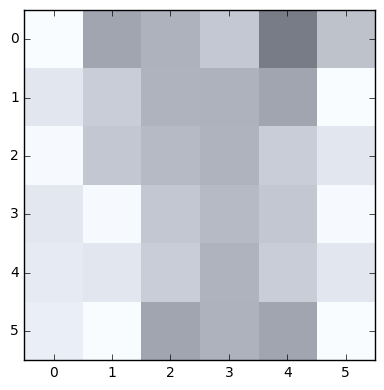

In [18]:
les0 = addBorder(les,3)
print(les0.shape[0], les0.shape[1])
imshow(les0[0:6, 0:6])
plt.show()

966


/home/nikon-cook/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


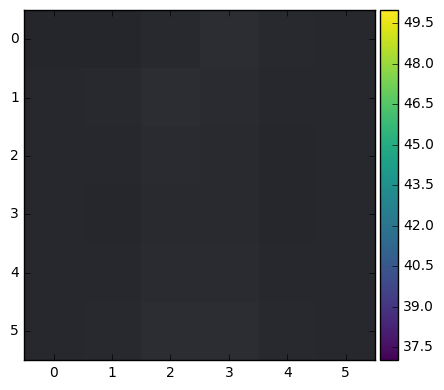

In [19]:
print(les0.shape[1])
imshow(les0[0:6, 960::])
plt.show()

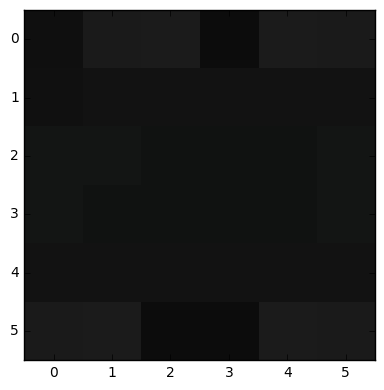

In [20]:
imshow(les0[960::, 0:6])
plt.show()

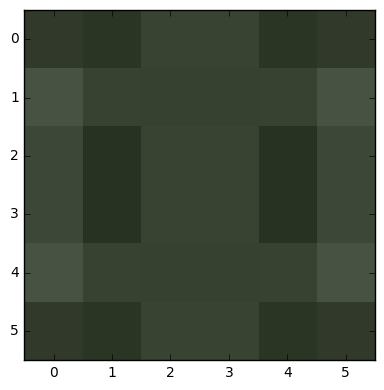

In [21]:
imshow(les0[960::, 960::])
plt.show()

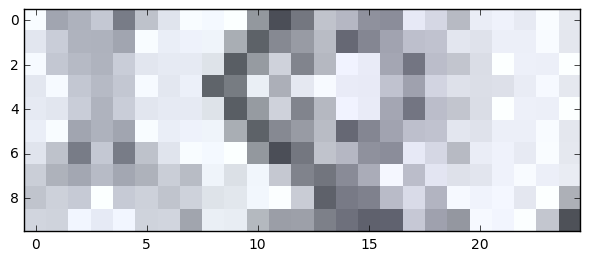

In [22]:
imshow(les0[0:10, 0:25])
plt.show()

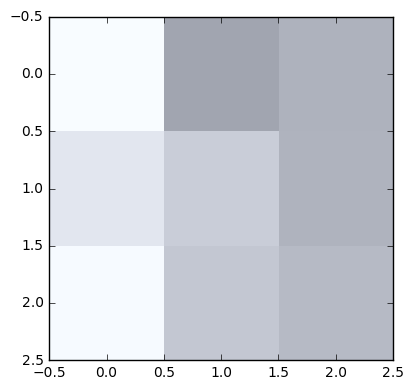

In [23]:
imshow(les0[0:3, 0:3])
plt.show()

960 960
2


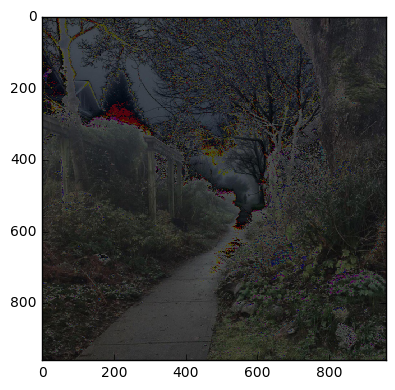

In [118]:
print(les.shape[0], les.shape[1])
les1 = bundle2(les, n1on9)
#imsave(les1, 'les11.jpg')
imshow(les1)
plt.show()

In [131]:
les11 = bundle3(les, n1on9)
imshow(les11)
plt.show()

3


ValueError: operands could not be broadcast together with shapes (3,3) (3,2) 

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


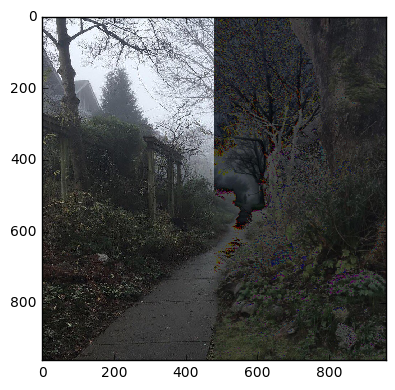

In [25]:
imsave('les_1.jpg', les1)
spliced_les_1 = splice2(les, les1)
imshow(spliced_les_1)
imsave('spliced_les_1.jpg', spliced_les_1)
difference_les_1 = np.abs(les1 - les)
imsave('difference_les_1.jpg', difference_les_1)
plt.show()

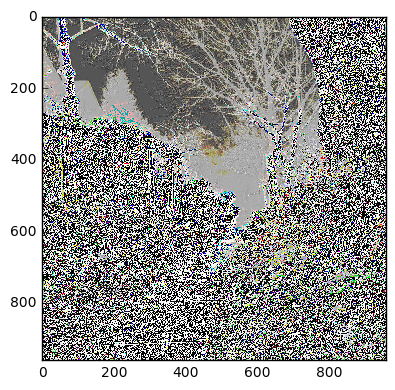

In [26]:
imshow(difference_les_1)
plt.show()

2


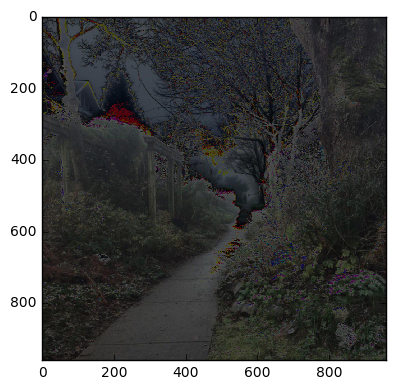

In [27]:
les2 = bundle2(les, n9)
#imsave(les1, 'les11.jpg')
imshow(les2)
plt.show()

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


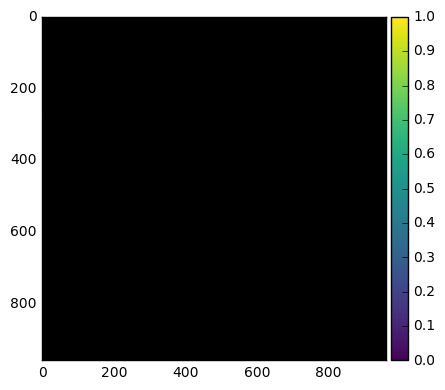

In [28]:
#imsave('les_2.jpg', les2)
#spliced_les_2 = splice2(les, les2)
#imshow(spliced_les_2)
#imsave('spliced_les_2.jpg', spliced_les_2)
difference_les_2 = np.abs(les2 - les1)
#imsave('difference_les_2.jpg', difference_les_2)
imshow(difference_les_2)
plt.show()

4


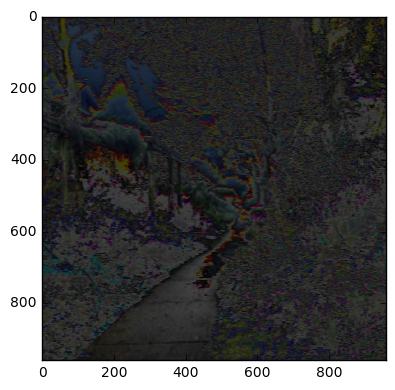

In [29]:
les3 = bundle2(les, nG)
imshow(les3)
plt.show()

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


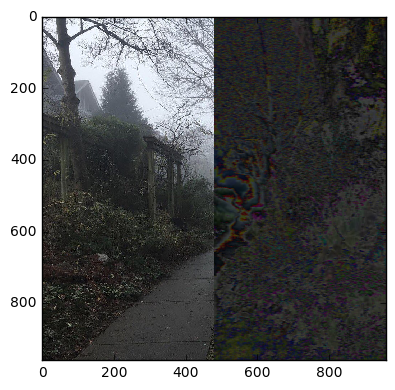

In [30]:
imsave('les_3.jpg', les3)
spliced_les_3 = splice2(les, les3)
imshow(spliced_les_3)
imsave('spliced_les_3.jpg', spliced_les_3)
difference_les_3 = np.abs(les - les3)
imsave('difference_les_3.jpg', difference_les_3)
plt.show()

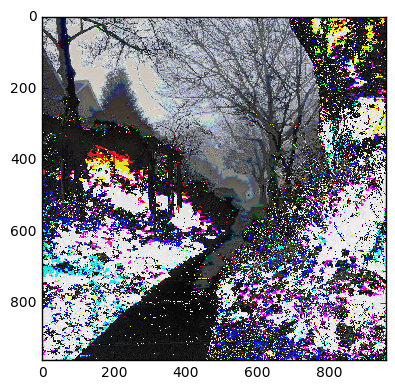

In [31]:
imshow(difference_les_3)
plt.show()

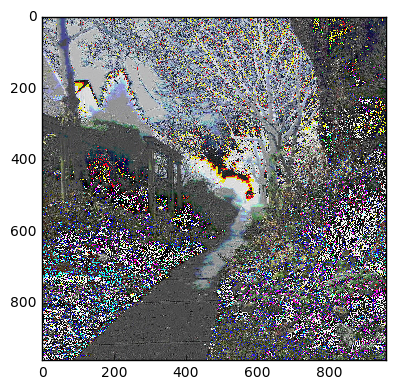

In [32]:
img_n_Gauss = np.abs(les + difference_les_3)
imshow(img_n_Gauss)
plt.show()

2


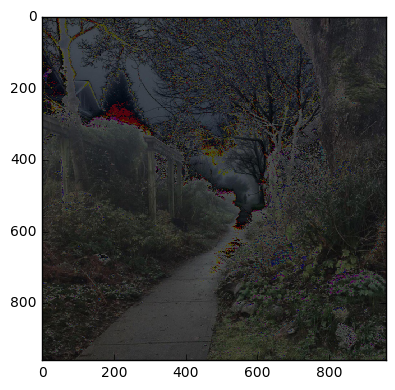

In [33]:
les4 = bundle2(les, n1to1)
imshow(les4)
plt.show()

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


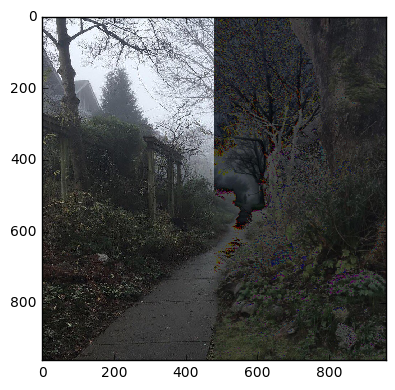

In [34]:
imsave('les_4.jpg', les4)
spliced_les_4 = splice2(les, les4)
imshow(spliced_les_4)
imsave('spliced_les_4.jpg', spliced_les_4)
difference_les_4 = np.abs(les4 - les)
imsave('difference_les_4.jpg', difference_les_4)
plt.show()

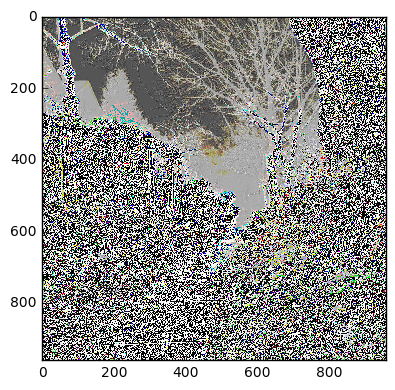

In [35]:
imshow(difference_les_4)
plt.show()

2


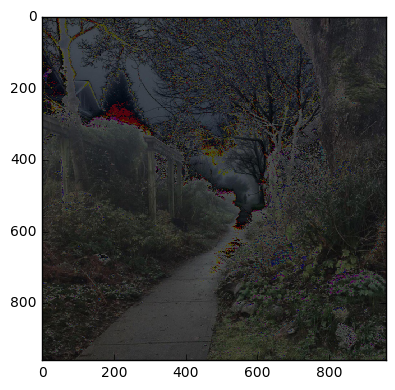

In [36]:
les5 = bundle2(les, n1on16)
imshow(les5)
plt.show()

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


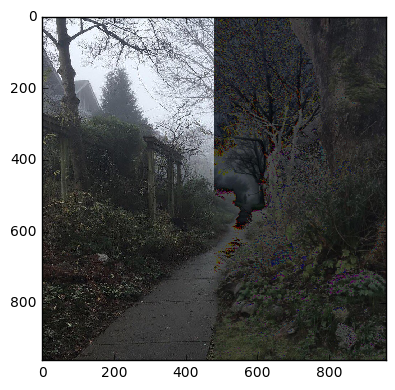

In [37]:
imsave('les_5.jpg', les5)
spliced_les_5 = splice2(les, les5)
imshow(spliced_les_5)
imsave('spliced_les_5.jpg', spliced_les_5)
difference_les_5 = np.abs(les5 - les)
imsave('difference_les_5.jpg', difference_les_5)
plt.show()

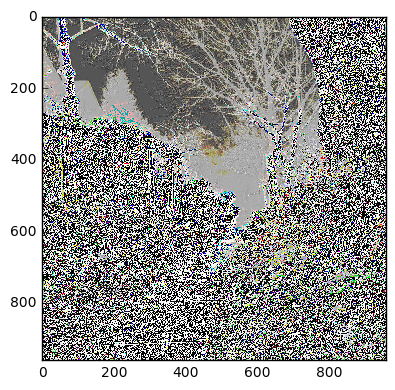

In [38]:
imshow(difference_les_5)
plt.show()

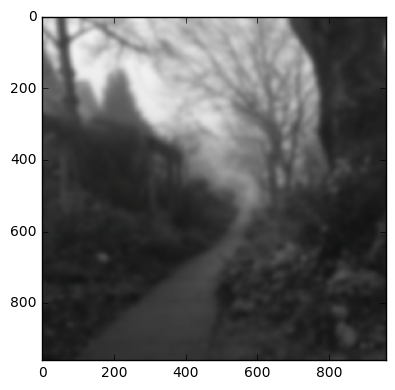

In [51]:
from scipy.ndimage.filters import gaussian_filter
les_Gauss = gaussian_filter(les, sigma=7)
imsave('les_Gauss.jpg', les_Gauss)
imshow(les_Gauss)
plt.show()

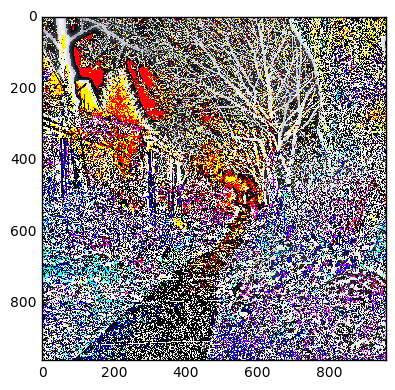

In [58]:
difference_les_Gauss = np.abs(les - les_Gauss)
imsave('difference_les_Gauss.jpg', difference_les_Gauss)
imshow(difference_les_Gauss)
plt.show()

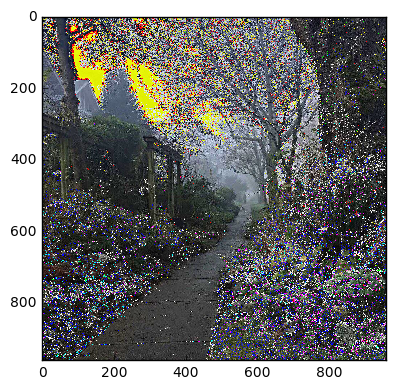

In [49]:
multiplication_les_Gauss = np.abs(les + difference_les_Gauss)
imsave('multiplication_les_Gauss.jpg', multiplication_les_Gauss)
imshow(multiplication_les_Gauss)
plt.show()

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/nikon-cook/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


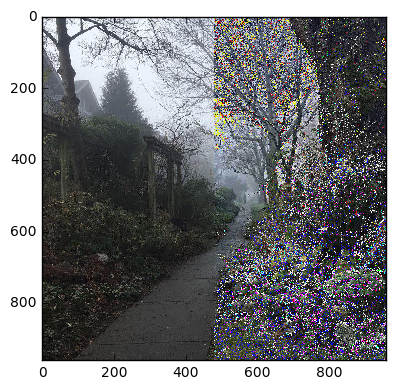

In [50]:
spliced_les_multipli = splice2(les, multiplication_les_Gauss)
imshow(spliced_les_multipli)
imsave('spliced_les_multipli.jpg', spliced_les_multipli)
plt.show()

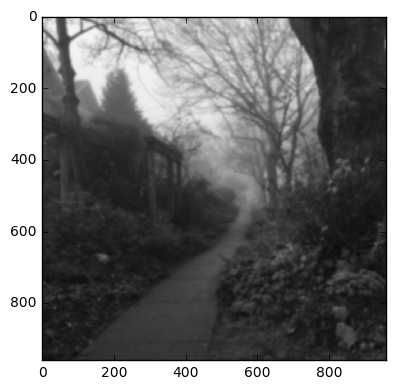

In [54]:
les_Gauss3 = gaussian_filter(les, sigma=3)
#imsave('les_Gauss.jpg', les_Gauss)
imshow(les_Gauss3)
plt.show()

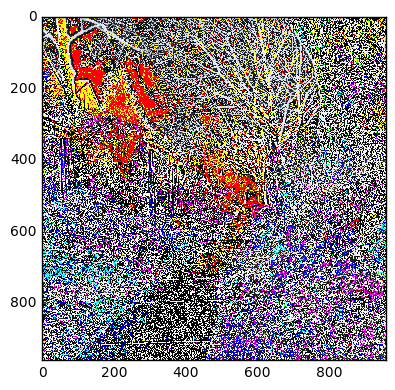

In [57]:
difference_les_Gauss3 = np.abs(les - les_Gauss3)
#imsave('difference_les_Gauss.jpg', difference_les_Gauss)
imshow(difference_les_Gauss3)
plt.show()

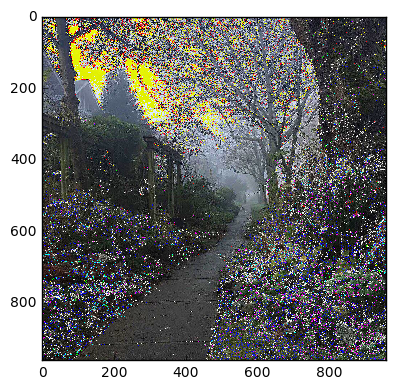

In [59]:
multiplication_les_Gauss3 = np.abs(les + difference_les_Gauss3)
#imsave('multiplication_les_Gauss.jpg', multiplication_les_Gauss)
imshow(multiplication_les_Gauss3)
plt.show()

In [61]:
room = imread('lab2/room.jpg')
text = imread('lab2/text1.jpg')
secret = imread('lab2/text2.jpg')

/home/nikon-cook/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


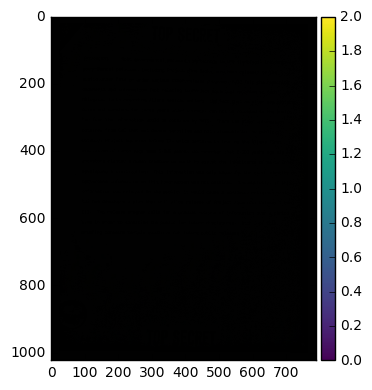

In [84]:
secret2 = gaussian_filter(secret, sigma=15)
secret3 = (secret / secret2)
#make_y(secret2)
imshow(secret3)
plt.show()

In [76]:
imsave('secret3.jpg', secret3)

ValueError: Images of type float must be between -1 and 1.